# Simultaneous Fit

Create a notebook to show how to do a simultaneous fit of two datasets with zfit.
Use RooFit example [rf501](https://root.cern/doc/master/rf501__simultaneouspdf_8py.html) as a reference.

In the example there is a physics and a control sample, and both samples are fitted simultaneously.

In [1]:
import zfit
import numpy as np

/Users/maurizio/Software/zfit/lib/python3.10/site-packages/zfit/__init__.py:62: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


## Create the Models

Let's start with the model of the physics sample. We will use a Gaussian distribution for the signal and a linear distribution for the background.

In [2]:
# create space
obs = zfit.Space("x", limits=(-8, 8))

# parameters
mu = zfit.Parameter("mean", 0, -8, 8)
sigma = zfit.Parameter("sigma", 0.3, 0.1, 10)
a0 = zfit.Parameter("a0", -0.1, -1, 1)
a1 = zfit.Parameter("a1", 0.004, -1, 1)
frac = zfit.Parameter("fraction", 0.2, 0, 1)

# model building, pdf creation
gauss = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
linear = zfit.pdf.Chebyshev(obs=obs, coeffs=[a0, a1])
model = zfit.pdf.SumPDF([gauss, linear], fracs=frac)

Now the model for the control sample

In [3]:
# parameters
mu_ctl = zfit.Parameter("mean_ctl", -3, -8, 8)
a0_ctl = zfit.Parameter("a0_ctl", -0.1, -1, 1)
a1_ctl = zfit.Parameter("a1_ctl", 0.5, -0.1, 1)
frac_ctl = zfit.Parameter("fraction_ctl", 0.5, 0, 1)

# model building, pdf creation
gauss_ctl = zfit.pdf.Gauss(mu=mu_ctl, sigma=sigma, obs=obs)
linear_ctl = zfit.pdf.Chebyshev(obs=obs, coeffs=[a0_ctl, a1_ctl])
model_ctl = zfit.pdf.SumPDF([gauss_ctl, linear_ctl], fracs=frac_ctl)

Now generate the data for both samples

In [4]:
# data
data = model.create_sampler(1000, limits=obs)
data.resample()
# data ctl
data_ctl = model_ctl.create_sampler(2000, limits=obs)
data_ctl.resample()

## Simultaneous fit

The simultaneous fit is done by summing the two loss functions of the models and the data of both samples.

$$
\mathcal{L}_{sim} = \mathcal{L}_{data}^{phys} + \mathcal{L}_{data}^{ctrl}
$$

In [5]:
# Create NLL
nll1 = zfit.loss.UnbinnedNLL(model=model, data=data)
nll2 = zfit.loss.UnbinnedNLL(model=model_ctl, data=data_ctl)
nll = nll1+nll2

In [6]:
# create a minimizer
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)

# do the error calculations, here with minos
param_errors, _ = result.errors()

/Users/maurizio/Software/zfit/lib/python3.10/site-packages/zfit/minimizers/fitresult.py:1318: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(
/Users/maurizio/Software/zfit/lib/python3.10/site-packages/zfit/minimizers/fitresult.py:1341: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.errors_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of errors (which is currently the method name such as `minuit_minos`or `zfit_errors`) has changed to `errors`. Old names are still added as well for compatibility but will be removed in the future. INSTRUCTIONS: to stay compatible, change wherever you access the error to 'errors' or specify the name expli

In [7]:
result

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_1, fraction], <zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_3, fraction_ctl]] data=[<zfit.core.data.Sampler object at 0x1623d2fe0>, <zfit.core.data.Sampler object at 0x1628ec430>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 8.7e-05 │ 995.0904    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name            value  (rounded)               errors         minuit_minos    at limit
------------  ------------------  -------------------  -------------------  ----------
fraction                0.189047  -  0.015   +  0.016  -  0.015   +  0.016       False
mean                  -0

## Plot the results

Now plot the results of the fit

### Control Sample

In [8]:
import os, sys
sys.path.append(f'{os.environ["PWD"]}/utilities')
from plotting import Plotter

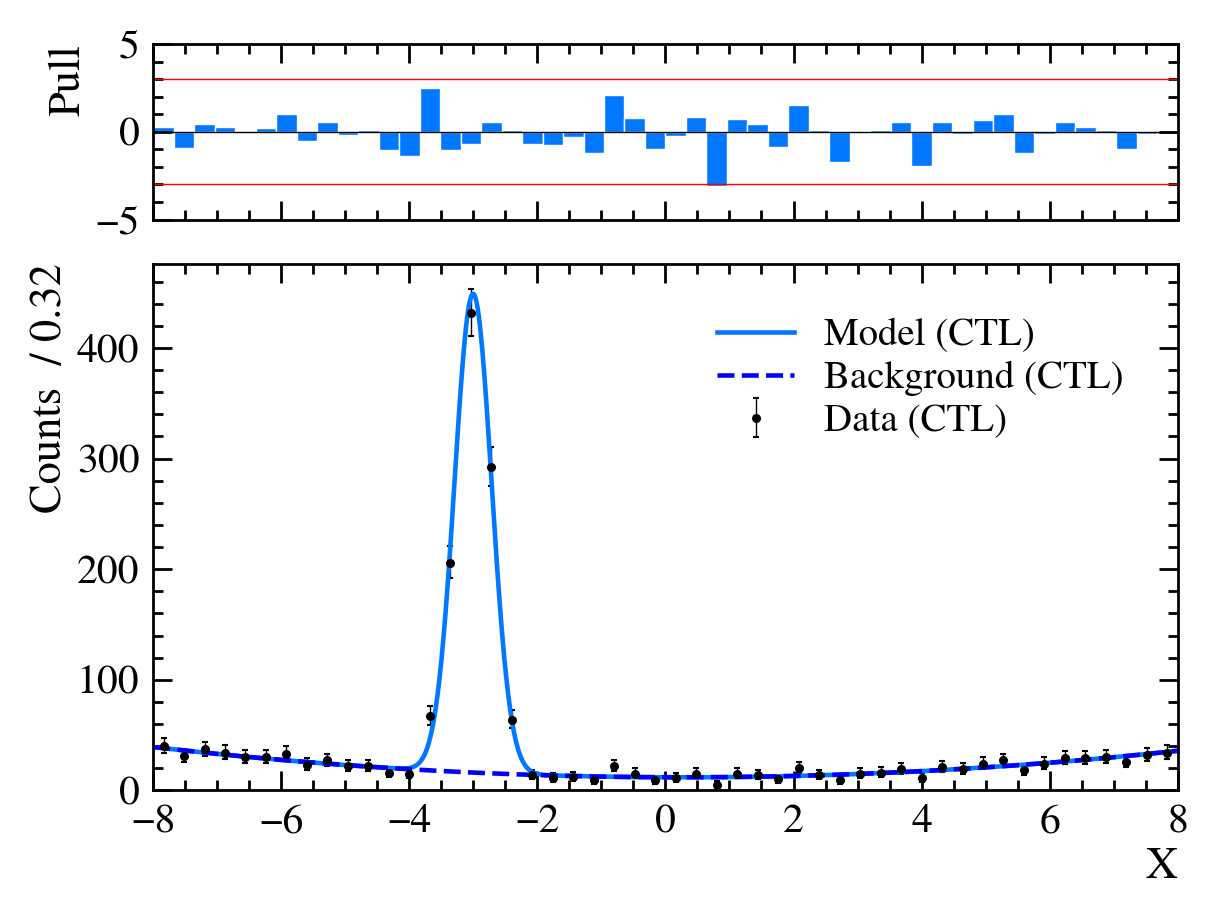

In [9]:
data_ctl_np = data_ctl.numpy()
plotter = Plotter(data_ctl_np, model_ctl, bins=50, range=(-8,8), xlabel='X', model_label='Model (CTL)', data_label='Data (CTL)')
plotter.add_component(linear_ctl, 1-frac_ctl, label='Background (CTL)', linestyle='--', color='b')
fig, axs = plotter.plot_fit_and_residuals()

### Signal Sample

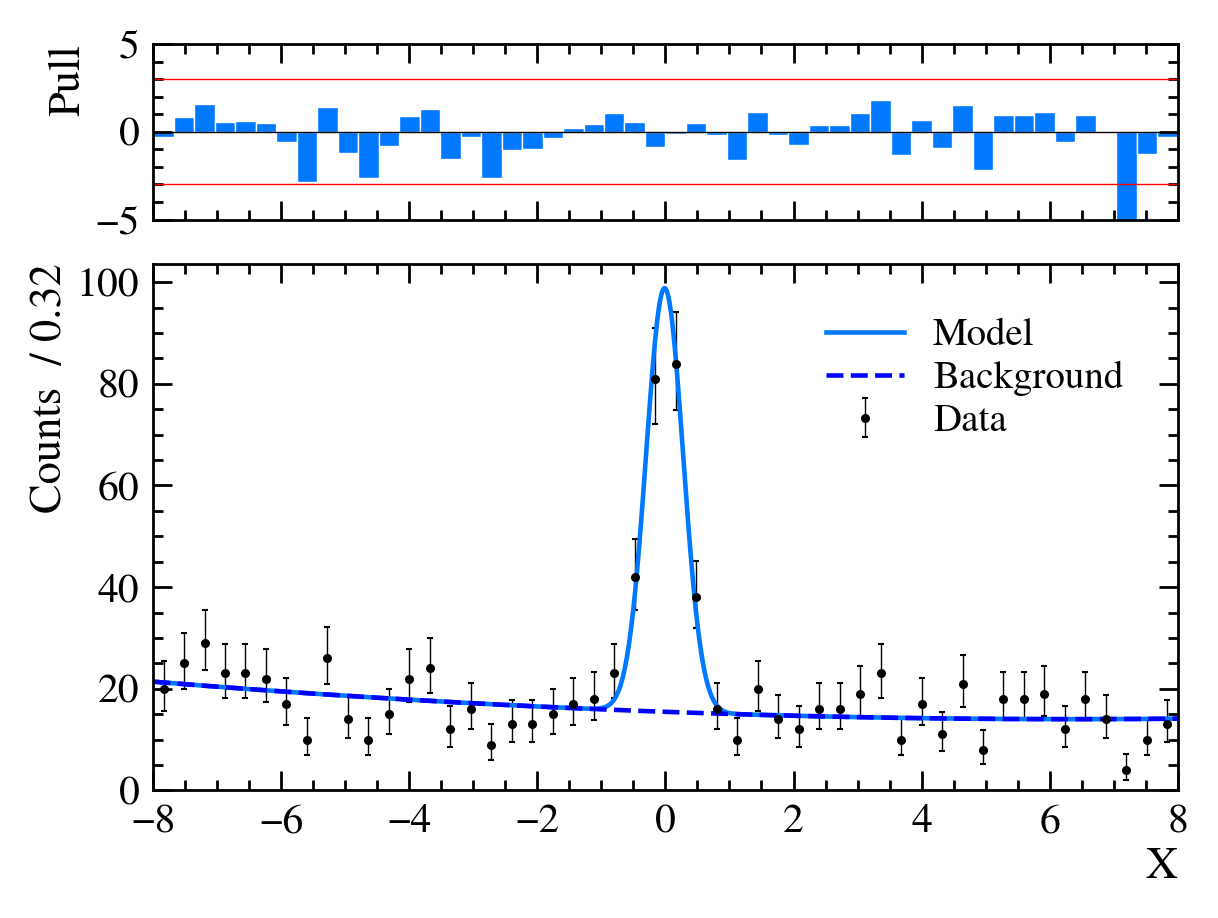

In [10]:
data_np = data.numpy()
plotter = Plotter(data_np, model, bins=50, range=(-8,8), xlabel='X', model_label='Model', data_label='Data')
plotter.add_component(linear, 1-frac, label='Background', linestyle='--', color='b')
fig, axs = plotter.plot_fit_and_residuals()

### Both Samples

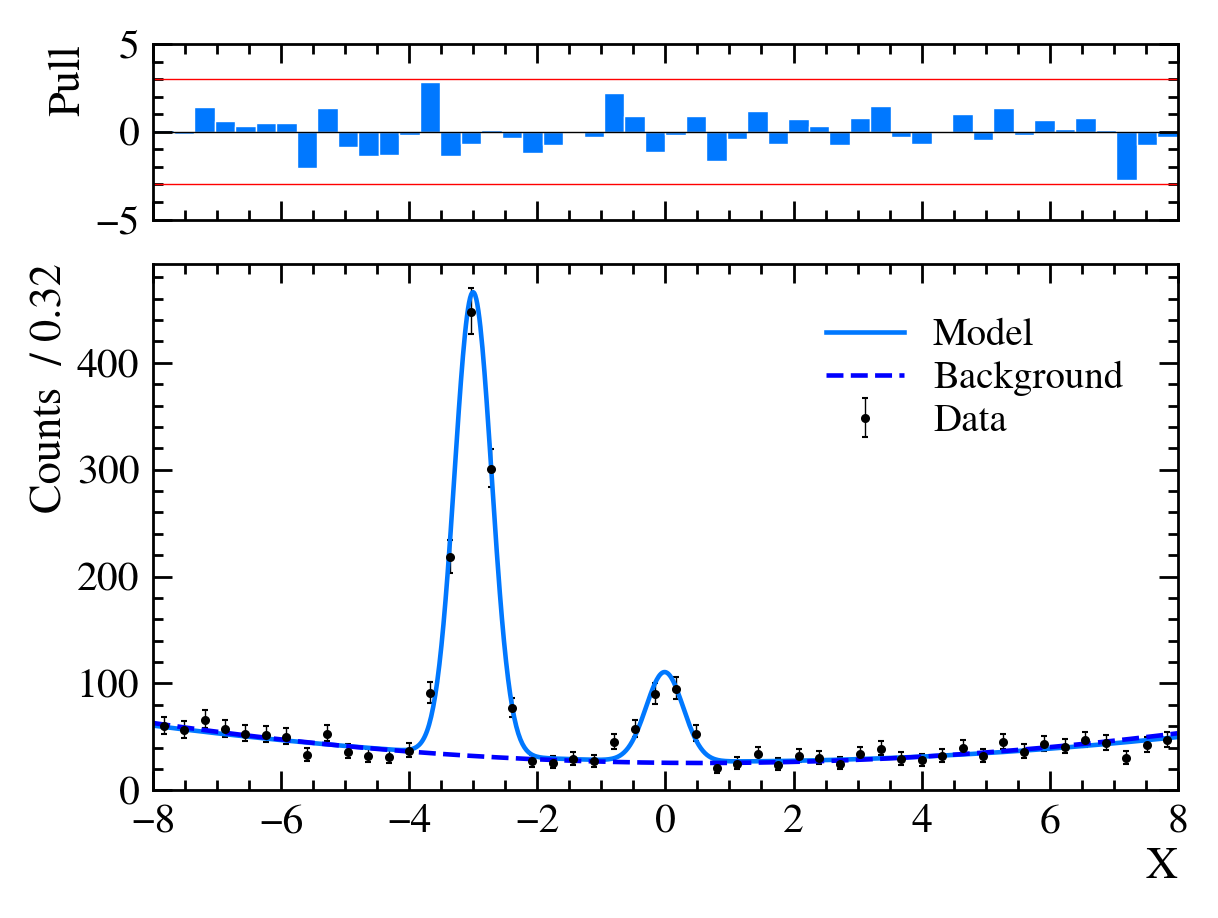

In [12]:
data_comb = np.copy(data_np)
data_comb = np.append(data_comb,data_ctl_np)
frac_sig = data_np.size/data_comb.size
model_comb = zfit.pdf.SumPDF([model, model_ctl], fracs=frac_sig)
linear_comb = zfit.pdf.SumPDF([linear, linear_ctl], fracs=frac_sig)
plotter = Plotter(data_comb, model_comb, bins=50, range=(-8,8), xlabel='X', model_label='Model', data_label='Data')
plotter.add_component(linear_comb, frac_sig*(1-frac)+(1-frac_sig)*(1-frac_ctl), label='Background', linestyle='--', color='b')
fig, axs = plotter.plot_fit_and_residuals()